The cross comparison method is proposed by Woz: https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithmic_contest:_SuperMemo_2_vs._SuperMemo_17

In [1]:
import pandas as pd
from pathlib import Path

dfs = []

for file in Path("./raw").glob("*.csv"):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
df.head()

,y,R (SM16),R (SM17),R (SM17(exp)),R (AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
0,1,0.841,0.866,0.866,0.641176,0.720,0.545,0.640,0.603,0.660
1,1,0.684,0.548,0.521,0.557143,0.464,0.340,0.478,0.444,0.582
2,1,0.698,0.667,0.479,0.900000,0.464,0.340,0.478,0.444,0.582
3,1,0.810,0.981,0.981,0.593333,0.730,0.503,0.654,0.622,0.740
4,1,0.796,0.916,0.847,0.595000,0.645,0.474,0.585,0.548,0.633


In [2]:
df.describe()

,y,R (SM16),R (SM17),R (SM17(exp)),R (AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
count,194281.000000,194281.000000,194281.000000,194281.000000,194281.000000,194281.000000,194281.000000,194281.000000,194281.000000,194281.000000
mean,0.866904,0.853812,0.878373,0.861429,0.839699,0.836510,0.827931,0.839939,0.837739,0.850369
std,0.339679,0.157799,0.152628,0.155297,0.075655,0.179846,0.176583,0.152642,0.154503,0.108861
min,0.000000,0.005000,0.000000,0.001000,0.064286,0.000000,0.004000,0.031000,0.031000,0.207000
25%,1.000000,0.822000,0.812000,0.845000,0.805372,0.802000,0.773000,0.782000,0.780000,0.795000
50%,1.000000,0.912000,0.932000,0.900000,0.866774,0.898000,0.890000,0.891000,0.889000,0.875000
75%,1.000000,0.950000,0.995000,0.948000,0.893810,0.949000,0.950000,0.949000,0.947000,0.932000
max,1.000000,0.999000,1.000000,0.999000,0.996970,1.000000,1.000000,1.000000,1.000000,1.000000


FSRS-6 log loss: 0.3630
SM17 log loss: 0.4599


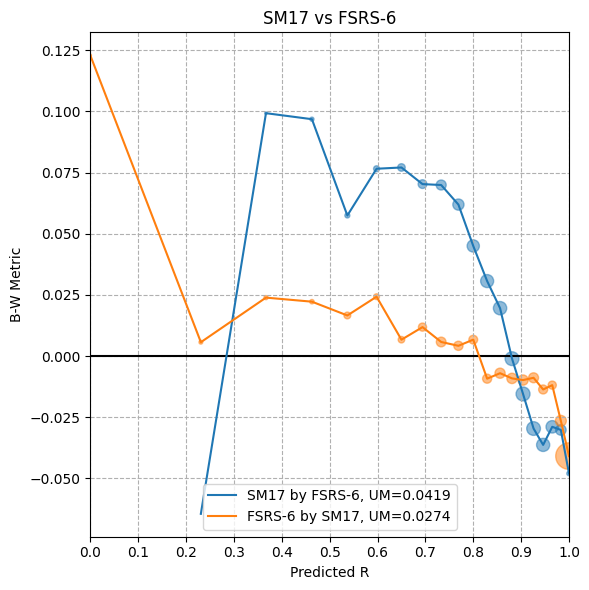

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error, log_loss


def cross_comparison(revlogs, algoA, algoB):
    cross_comparison_record = revlogs[[f"R ({algoA})", f"R ({algoB})", "y"]].copy()

    def get_bin(x, bins=20):
        return (np.log(np.exp(np.log(bins) * x).round()) / np.log(bins)).round(3)

    for algo in (algoA, algoB):
        cross_comparison_record[f"{algo}_B-W"] = (
            cross_comparison_record[f"R ({algo})"] - cross_comparison_record["y"]
        )
        cross_comparison_record[f"{algo}_bin"] = cross_comparison_record[
            f"R ({algo})"
        ].map(get_bin)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()
    ax.axhline(y=0.0, color="black", linestyle="-")

    for algoA, algoB in [(algoA, algoB), (algoB, algoA)]:
        cross_comparison_group = cross_comparison_record.groupby(by=f"{algoA}_bin").agg(
            {"y": ["mean"], f"{algoB}_B-W": ["mean"], f"R ({algoB})": ["mean", "count"]}
        )
        universal_metric = root_mean_squared_error(
            cross_comparison_group["y", "mean"],
            cross_comparison_group[f"R ({algoB})", "mean"],
            sample_weight=cross_comparison_group[f"R ({algoB})", "count"],
        )
        cross_comparison_group[f"R ({algoB})", "percent"] = (
            cross_comparison_group[f"R ({algoB})", "count"]
            / cross_comparison_group[f"R ({algoB})", "count"].sum()
        )
        ax.scatter(
            cross_comparison_group.index,
            cross_comparison_group[f"{algoB}_B-W", "mean"],
            s=cross_comparison_group[f"R ({algoB})", "percent"] * 1024,
            alpha=0.5,
        )
        ax.plot(
            cross_comparison_group[f"{algoB}_B-W", "mean"],
            label=f"{algoB} by {algoA}, UM={universal_metric:.4f}",
        )

    ax.legend(loc="lower center")
    ax.grid(linestyle="--")
    ax.set_title(f"{algoA} vs {algoB}")
    ax.set_xlabel("Predicted R")
    ax.set_ylabel("B-W Metric")
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    plt.tight_layout()
    plt.show()


print(f"FSRS-6 log loss: {log_loss(df['y'], df['R (FSRS-6)']):.4f}")
print(f"SM17 log loss: {log_loss(df['y'], df['R (SM17)']):.4f}")
cross_comparison(df, "FSRS-6", "SM17")

FSRS-6 log loss: 0.3630
SM17(exp) log loss: 0.4137


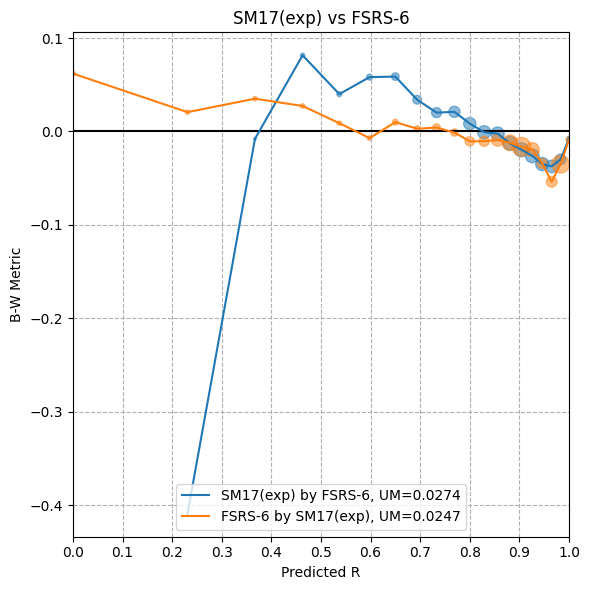

In [4]:
print(f"FSRS-6 log loss: {log_loss(df['y'], df['R (FSRS-6)']):.4f}")
print(f"SM17(exp) log loss: {log_loss(df['y'], df['R (SM17(exp))']):.4f}")
cross_comparison(df, "FSRS-6", "SM17(exp)")

SM17 log loss: 0.4599
SM17(exp) log loss: 0.4137


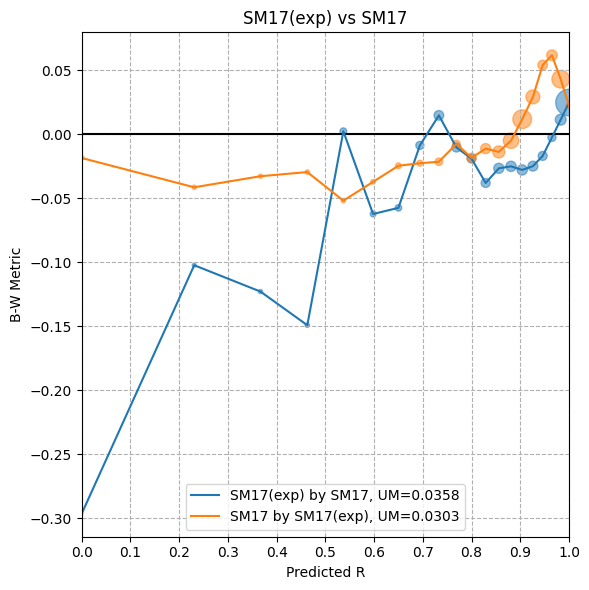

In [5]:
print(f"SM17 log loss: {log_loss(df['y'], df['R (SM17)']):.4f}")
print(f"SM17(exp) log loss: {log_loss(df['y'], df['R (SM17(exp))']):.4f}")
cross_comparison(df, "SM17", "SM17(exp)")

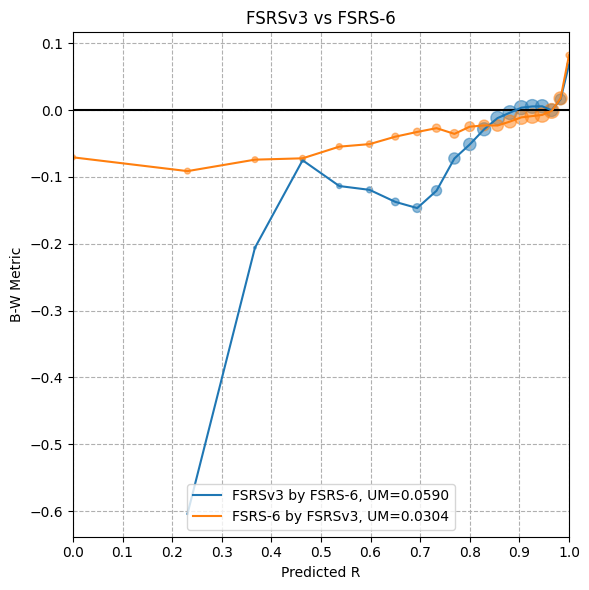

In [6]:
cross_comparison(df, "FSRS-6", "FSRSv3")

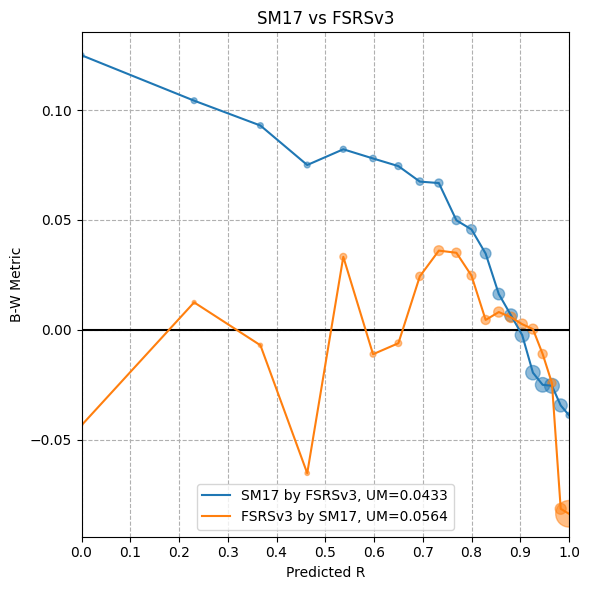

In [7]:
cross_comparison(df, "FSRSv3", "SM17")

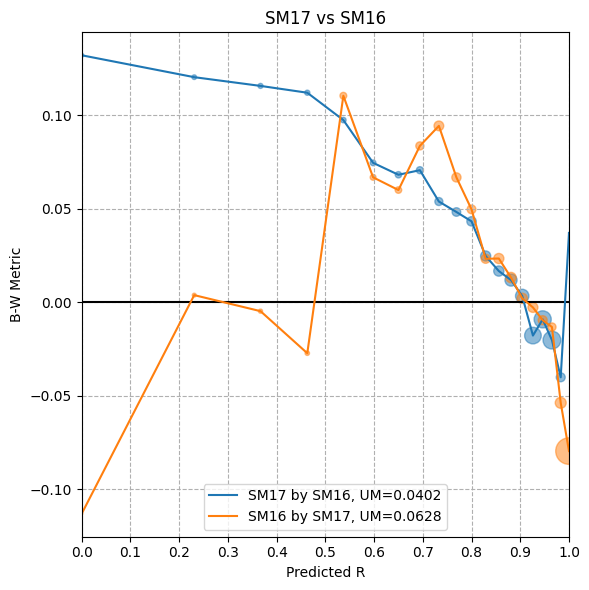

In [8]:
cross_comparison(df, "SM16", "SM17")

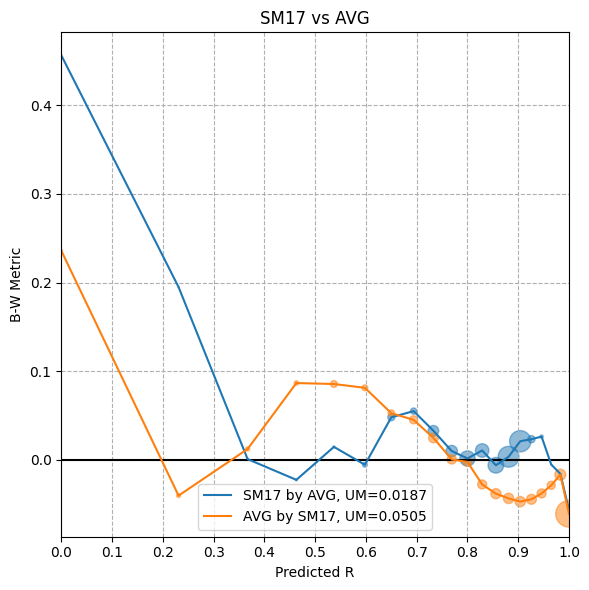

In [9]:
cross_comparison(df, "AVG", "SM17")